In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

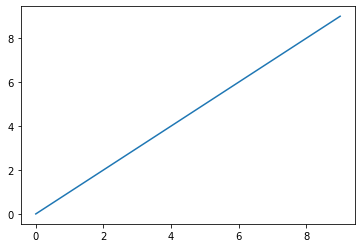

In [2]:
plt.plot(range(10), range(10))

In [3]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

from utils.utils_dataset import *
from utils.utils_unet import *
from utils.utils_training import *




root = '.'

# Retrieve data and include transformation operations
print('Retrieving Data')

train_path_images = root + '/datasets/training/images'
train_path_target = root + '/datasets/training/1st_manual'
train_path_mask = root + '/datasets/training/mask'
test_path = root + '/datasets/test/images'

# transformations

# alternative using Random Operations function
'''
train_transform = transforms.Compose([RandomOperations([RandomHorizontalFlip(p = 1),
                                                        RandomVerticalFlip(p = 1)],
                                                       weights = [.5, .5]),
                                      RandomRotate(degrees = 180),
                                      ToTensor()])
'''
train_transform = transforms.Compose([RandomHorizontalFlip(p = .5),
                                     RandomVerticalFlip(p = .5),
                                     RandomRotate(degrees = 180),
                                     ToTensor()])

test_transform = ToTensor()

# retrieve dataset
train_dataset = CustomDataset(image_root=train_path_images,
                              target_root=train_path_target,
                              mask_root=train_path_mask,
                              transform=train_transform)
test_dataset = CustomDataset(image_root=test_path,
                             transform = test_transform)


# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print('Device:', device)


# Put data into dataloaders
print('Loading DataLoaders')

# batch sizes
train_batch_size = 1
val_batch_size = 1
test_batch_size = 1

# split into train and val
train_size = int(len(train_dataset) * .7)
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# load into dataloaders
train_loader = DataLoader(train_data, batch_size = train_batch_size, shuffle = False)
val_loader = DataLoader(val_data, batch_size = val_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True )


Retrieving Data
Device: cpu
Loading DataLoaders


In [4]:
# set up UNET and Optimizers
print('Setting up UNet')
unet = UNet(init_channels = 3,
            filters = 64,
            output_channels = 2,
            pool_mode = 'max',
            up_mode = 'upconv', 
            connection = 'cat',
            same_padding = True,
            use_batchnorm = True,
            conv_layers_per_block = 2
            )

# !!!!! SET UP INITIAL WEIGHTS according to article
unet.to(device)

# optimizer parameters
params = unet.parameters()
lr = .01
momentum = .99 # according to article
optimizer = optim.SGD(params, lr = lr, momentum = momentum )

# loss function
loss_fn = nn.BCELoss()

# LR scheduler (for later )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=.1,
                                                 patience=5,
                                                 verbose=True)

# training cycle
print('Training')

# validate once on random initialization

val_loss = val_epoch(epoch=0,
                     network=unet,
                     loss_fn=loss_fn,
                     dataloader=val_loader,
                    device = device)
print(f'No Training Validation Loss - {val_loss}')


Setting up UNet


Validating


Training


/opt/anaconda3/envs/algo_trade/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [ ]:

num_epochs = 1000
values = {'train_loss': [], 'val_loss': []}
for epoch in range(1, num_epochs + 1):
    #train

    train_loss = train_epoch(epoch=epoch,
                           network=unet,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           dataloader=train_loader,
                            device = device,
                            save_location = './models/')
    #validate
    val_loss = val_epoch(epoch=0,
                     network=unet,
                     loss_fn=loss_fn,
                     dataloader=val_loader,
                    device = device)

    #report metrics
    print(f'Train Loss: {train_loss}\nVal Loss: {val_loss}')
    values['train_loss'].append(train_loss)
    values['val_loss'].append(val_loss)

    plot_test_epoch(epoch=epoch,
                   network=unet,
                   dataloader=test_loader,
                   num_cols=2)
    # change lr
    scheduler.step(val_loss)

In [ ]:
plot_test_epoch

In [ ]:
len(val_loader)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

example = enumerate(val_loader)
next(example)
batch_idx, (example_image, example_gt, example_mask)= next(example)
print(example_image.size())
fig.suptitle('Train Example 1')
ax[0].imshow(transforms.ToPILImage()(example_image[0]))
ax[1].imshow(transforms.ToPILImage()(example_gt[0]),cmap = 'gray')
ax[2].imshow(transforms.ToPILImage()(example_mask[0]),cmap = 'gray')

In [ ]:
split_target(example_gt).size()

In [ ]:
plt.imshow(transforms.ToPILImage()(split_target(example_gt)[0][1]),cmap = 'gray')

In [ ]:
seg = unet(example_image)

In [ ]:
seg.size()

In [ ]:
torch.cat([example_mask, example_mask], dim = 1).size()

In [ ]:
new_seg, new_gt = get_masked(seg, split_target(example_gt), example_mask, device = 'cpu')

In [ ]:
new_seg.size()

In [ ]:
new_gt.size()

In [ ]:
plt.imshow(transforms.ToPILImage()(new_gt[0][1]),cmap = 'gray')

In [ ]:
new_gt.min()

In [ ]:
unet

In [ ]:
unet.ub1_upsample[0].in_channels